Connected to Python 3.12.2

# CREDIT RISK PREDICTION NOTEBOOK

Our Goal in this Notebook is to build a model that will help us predict the risk of a credit card applicant based on their personal information and other factors. 

We want to build an algorithm which can accurately identify applicants who are at high risk for defaulting on their credit cards.

## Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import math
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_curve, auc

## Read and Describe Dataset

In [2]:
df=pd.read_csv(r".\\ressources\\credit_risk_dataset.csv")
df.columns.to_list()

['person_age',
 'person_income',
 'person_home_ownership',
 'person_emp_length',
 'loan_intent',
 'loan_grade',
 'loan_amnt',
 'loan_int_rate',
 'loan_status',
 'loan_percent_income',
 'cb_person_default_on_file',
 'cb_person_cred_hist_length']

In [3]:
#Prettifying columnnames
pretty_columns_list=columns = [
    "Person's Age",
    "Person's Income",
    "Home Ownership Status",
    "Employment Length",
    "Loan Intent",
    "Loan Grade",
    "Loan Amount",
    "Interest Rate",
    "Loan Status",
    "Loan Percentage of Income",
    "Default History on File",
    "Credit History Length"
]
df.columns=pretty_columns_list

### Descriptions

1. **Person's Age**: The age of the person applying for the loan.
2. **Person's Income**: The income of the person applying for the loan (annually).
3. **Home Ownership Status**: The home ownership status of the person.
4. **Employment Length**: The length of employment of the person in years.
5. **Loan Intent**: The purpose or intent for which the loan is being taken.
6. **Loan Grade**: The grade assigned to the loan, used as a proxy for credit quality (low risk to high risk). 
7. **Loan Amount**: The amount of the loan requested or disbursed.
8. **Interest Rate**: The interest rate on the loan.
9. **Loan Status**: The status of the loan 0=Not Default, 1=Default. This is our target variable for modeling.
10. **Loan Percentage of Income**: The percentage of the person's income that the loan amount represents.
11. **Default History on File**: Indicates whether the person has a history of default (e.g., Y for yes, N for no).
12. **Credit History Length**: The length of the person's credit history.

### Data Exploration

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Person's Age               32581 non-null  int64  
 1   Person's Income            32581 non-null  int64  
 2   Home Ownership Status      32581 non-null  object 
 3   Employment Length          31686 non-null  float64
 4   Loan Intent                32581 non-null  object 
 5   Loan Grade                 32581 non-null  object 
 6   Loan Amount                32581 non-null  int64  
 7   Interest Rate              29465 non-null  float64
 8   Loan Status                32581 non-null  int64  
 9   Loan Percentage of Income  32581 non-null  float64
 10  Default History on File    32581 non-null  object 
 11  Credit History Length      32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


### Handling missing Values

First we check how many missing values there are in each column of the dataset.

In [5]:
print(df.isnull().sum() if (df.isnull().sum() > 0).any() else "")

Person's Age                    0
Person's Income                 0
Home Ownership Status           0
Employment Length             895
Loan Intent                     0
Loan Grade                      0
Loan Amount                     0
Interest Rate                3116
Loan Status                     0
Loan Percentage of Income       0
Default History on File         0
Credit History Length           0
dtype: int64


In order to see if we can drop the missing values or if need to augment some data, we have to check our target.

In [6]:
y=df[['Loan Status']] # Target column
X=df.drop('Loan Status',axis=1) # Features column
print(y.value_counts())
print("--------------------")
print(round(y.value_counts()[1]/y.value_counts()[0],2))

Loan Status
0              25473
1               7108
Name: count, dtype: int64
--------------------
0.28


28-72 is a good ratio, we can augment some data, but it is not necessary.

In [7]:
df.dropna(inplace=True)
print("At least one missing value!" if (df.isnull().sum()).any==True else "No missing value after updating!")
y=df[['Loan Status']] # Target column
X=df.drop('Loan Status',axis=1) # Features column

No missing value after updating!


In [8]:
print(y.value_counts())
print("--------------------")
print(round(y.value_counts()[1]/y.value_counts()[0],2))

Loan Status
0              22435
1               6203
Name: count, dtype: int64
--------------------
0.28


Even after dropping some rows, we still have enough data to train our model.

## Exploratory Data Analysis and Data Preparation

Here we get an overview of the data.

In [9]:
df.describe(include=['number']) #numeric columns

Person's Age  Person's Income  Employment Length   Loan Amount  \
count  28638.000000     2.863800e+04       28638.000000  28638.000000   
mean      27.727216     6.664937e+04           4.788672   9656.493121   
std        6.310441     6.235645e+04           4.154627   6329.683361   
min       20.000000     4.000000e+03           0.000000    500.000000   
25%       23.000000     3.948000e+04           2.000000   5000.000000   
50%       26.000000     5.595600e+04           4.000000   8000.000000   
75%       30.000000     8.000000e+04           7.000000  12500.000000   
max      144.000000     6.000000e+06         123.000000  35000.000000   

       Interest Rate   Loan Status  Loan Percentage of Income  \
count   28638.000000  28638.000000               28638.000000   
mean       11.039867      0.216600                   0.169488   
std         3.229372      0.411935                   0.106393   
min         5.420000      0.000000                   0.000000   
25%         7.900000      0.000000                   0.090000   
50%        10.990000      0.000000                   0.150000   
75%        13.480000      0.000000                   0.230000   
max        23.220000      1.000000                   0.830000   

       Credit History Length  
count           28638.000000  
mean                5.793736  
std                 4.038483  
min                 2.000000  
25%                 3.000000  
50%                 4.000000  
75%                 8.000000  
max                30.000000

We can see, that we have some outliers already.

There is nobody known to be 144 years old. so this is probably a mistake in the data. Neither did anyone work 123 years. 
We will adress this issues later on.

For now let's see the categorical columns and see if we get to learn something out of it for our process.

In [10]:
df.describe(include=['object']) #categorical columns

Home Ownership Status Loan Intent Loan Grade Default History on File
count                  28638       28638      28638                   28638
unique                     4           6          7                       2
top                     RENT   EDUCATION          A                       N
freq                   14551        5704       9402                   23535

We later gonna use some of these values to explore the data in more detail and in order to understand the training process.

In [11]:
df.head()

Person's Age  Person's Income Home Ownership Status  Employment Length  \
0            22            59000                  RENT              123.0   
1            21             9600                   OWN                5.0   
2            25             9600              MORTGAGE                1.0   
3            23            65500                  RENT                4.0   
4            24            54400                  RENT                8.0   

  Loan Intent Loan Grade  Loan Amount  Interest Rate  Loan Status  \
0    PERSONAL          D        35000          16.02            1   
1   EDUCATION          B         1000          11.14            0   
2     MEDICAL          C         5500          12.87            1   
3     MEDICAL          C        35000          15.23            1   
4     MEDICAL          C        35000          14.27            1   

   Loan Percentage of Income Default History on File  Credit History Length  
0                       0.59                       Y                      3  
1                       0.10                       N                      2  
2                       0.57                       N                      3  
3                       0.53                       N                      2  
4                       0.55                       Y                      4

First we are going to sort the data like previously. We separate them by their datatypes.

In [12]:
num_columns=X.select_dtypes(include="number").columns.to_list() #numeric columns
cat_columns=X.select_dtypes(exclude="number").columns.to_list() #categorical columns

Now we are going to see the data in more detail with techniques used for those datatypes.

### Numeric Data

To see the relations between those numbers we first calculate and visualize the correlation matrix.


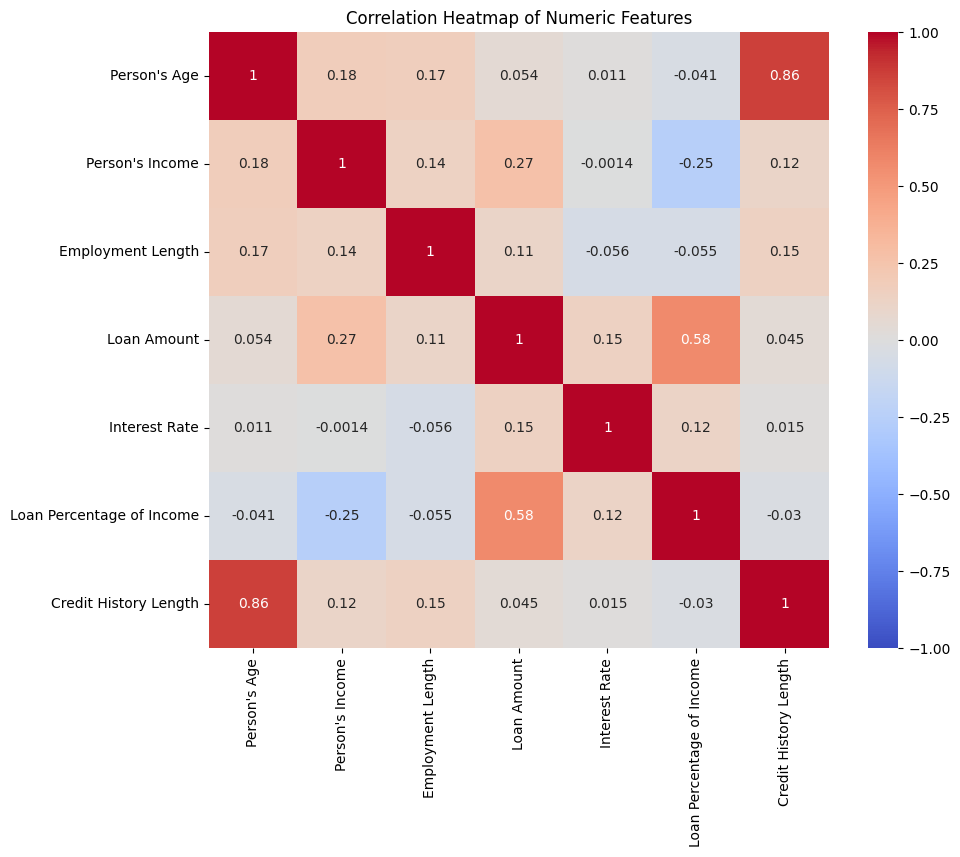

In [13]:
# Calculate the correlation matrix for numeric columns
correlation_matrix = df[num_columns].corr()

# Create a mask to hide all the less correlated data 
# (For better visualizations we let this to the user to decide for now, later we are going to use this for our feature selection)
threshhold=0
mask = correlation_matrix.map(lambda val: bool(abs(val)<threshhold))

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, vmin=-1, vmax=1, mask=mask)

# Display the plot
plt.title('Correlation Heatmap of Numeric Features')
plt.show()


We can see that there are two main correlations in our dataset:

- Credit history length and a person's age

- Loan percentage of income and loan amount

This is not surprising, since loans are not granted to minors, and if someone takes an early loan, they will have a history to show after a few years.
What is interesting, however, is that we have very young customers (the mean age is around 27). To check whether they were granted early loans or not, we are going to investigate this further.

Furthermore, we see that the higher the loan percentage of income, the higher the loan amount. This is also not very surprising, as the loan installment increases with the loan amount.

Let's see the data with high correlation.

First we visualize the data with a scatter plot between "Person's Age" and "Credit History Length".

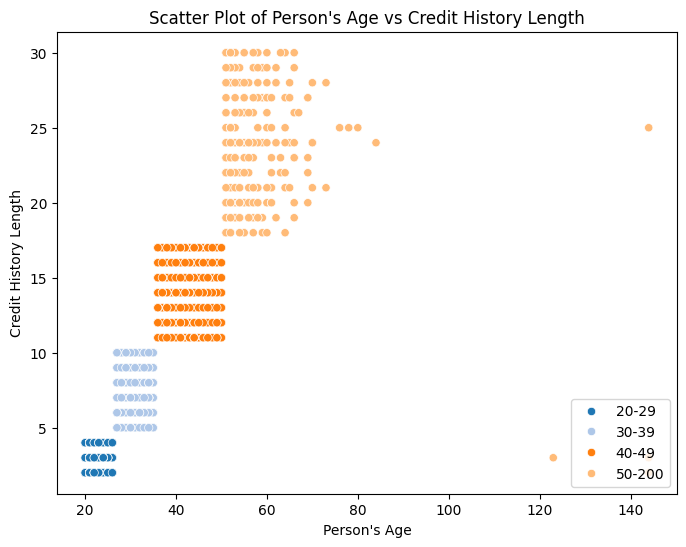

In [14]:
# Select two numerical columns
col1 = "Credit History Length"
col2 = "Person's Age"

# Create scatter plot
plt.figure(figsize=(8, 6))
# Define intervals for coloring
bins = [18, 26, 35, 50, df[col2].max()]
labels=  ['20-29', '30-39', '40-49', '50-200']
# Create intervals for the x-axis values
df['Age_Group'] = pd.cut(df[col2], bins=bins, labels=labels, include_lowest=True)

# Create scatter plot with different colors for age groups
sns.scatterplot(x=df[col2], y=df[col1], hue=df['Age_Group'], palette='tab20')
plt.title(f"Scatter Plot of {col2} vs {col1}")
plt.legend(loc="lower right")
plt.show()

To minimize multicollinearity, we should drop one of the highly correlated variables from our training data. The variables in question are Credit History Length and Person's Age, and they appear to have been tracked at a clear interval.

To maximize accuracy, we should consider dropping the Credit History Length column from our training data and keeping the Person's Age column. Age is a continuous variable with higher data quality.

In [15]:
num_columns.remove("Credit History Length")

Now let's visualize the other main correlation.

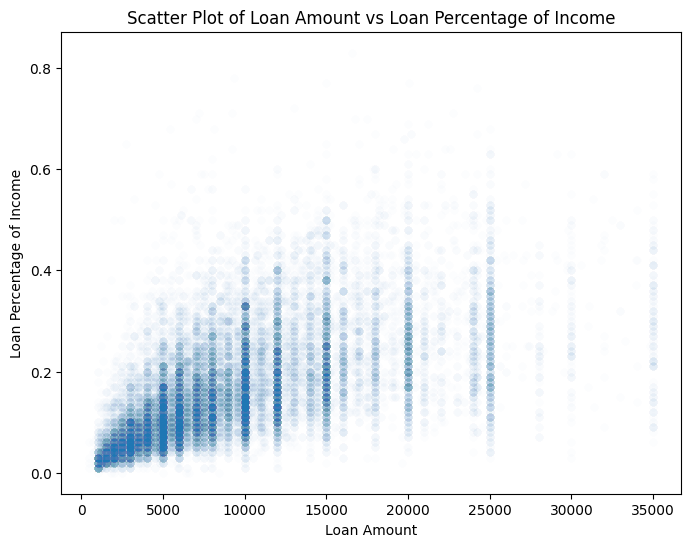

In [16]:
# Select two numerical columns
col1 = "Loan Amount"
col2 = "Loan Percentage of Income"

# Create scatter plot
plt.figure(figsize=(8, 6))

# Create scatter plot with different colors for age groups
sns.scatterplot(x=df[col1], y=df[col2], alpha=0.01)
plt.xlabel(col1)
plt.ylabel(col2)
plt.title(f"Scatter Plot of {col1} vs {col2}")
plt.show()

We can approve what we saw in our correlation matrix.
There is a moderate positive relationship in our data.

In order to reduce multicollinearity we can reduce the dimensionality once again. This time we have no preference based on the data collection so we use another approach.
We deal with a linear relation so we can use PCA to reduce the dimensionality. 

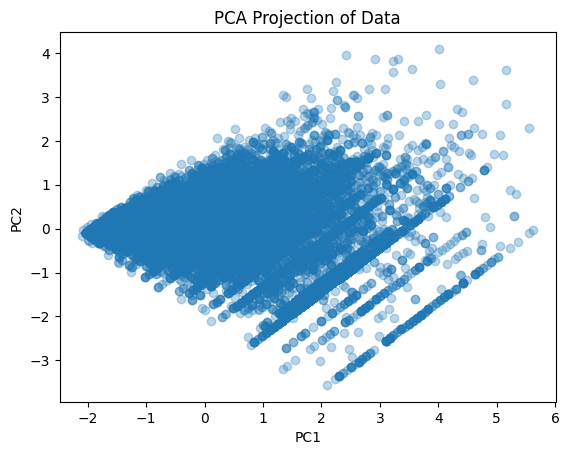

In [17]:
# Select our columns to be used for PCA
X_pre_pca = df[["Loan Amount", "Loan Percentage of Income"]].values

# Scale our data
X_scaled = StandardScaler().fit_transform(X_pre_pca)

# Create PCA object and fit the data
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Create a scatter plot of the PCA projection
plt.scatter(X_pca[:,0], X_pca[:,1], alpha=0.3)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA Projection of Data")
plt.show()

To be able to see the meaning of these principal components, we first scale our data and then we plot the eigenvalues on it.

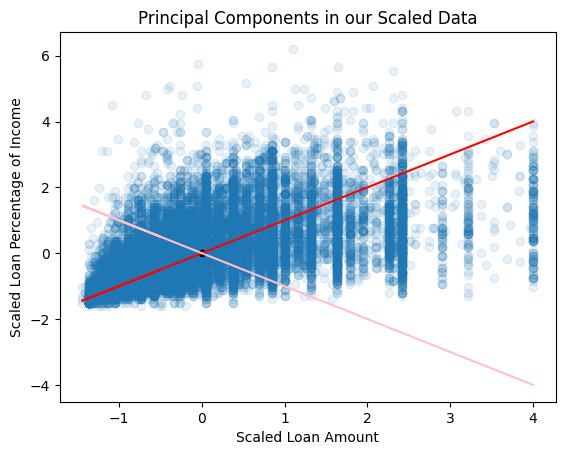

In [18]:
# Scatter plot of scaled data
plt.scatter(X_scaled[:,0], X_scaled[:,1], alpha=0.1)

# Line along first and second principal component
y1_vals = (pca.components_[0,1]/pca.components_[0,0]) * (X_scaled[:,0])
y2_vals = (pca.components_[1,1]/pca.components_[1,0]) * (X_scaled[:,0])

plt.plot(X_scaled[:,0], y1_vals, color="red")
plt.plot(X_scaled[:,0], y2_vals, color="pink")

# Black point at origin
plt.scatter(0, 0, color="black", s=20)

plt.xlabel("Scaled " + col1)
plt.ylabel("Scaled " + col2)
plt.title(f"Principal Components in our Scaled Data")
plt.show()

Now it is very clear, we express our data in new coordinates.

And with PCA we reduced the dimension and defined a new feature.

So we now see what PCA gave us as a result.

In [19]:
# Print the explained variance ratio
print("Explained variance ratio: \n", pca.explained_variance_ratio_)

# Print the eigenvalues
print("Explained variance (Eigenvalues): \n", pca.explained_variance_)

# Print the eigenvectors
print("PCA components (Eigenvectors): \n",pca.components_)

Explained variance ratio: 
 [0.78869967 0.21130033]
Explained variance (Eigenvalues): 
 [1.57745441 0.42261543]
PCA components (Eigenvectors): 
 [[ 0.70710678  0.70710678]
 [-0.70710678  0.70710678]]


PC1 explains almost 80% of the variance → the main axis of data spread.

PC2 explains only 20% → orthogonal, contributing less.

So we will use the PC1 to train our data, as we have a very small informationloss.

In [20]:
df["PC1"]=y1_vals
if "PC1" not in num_columns:
    num_columns.append("PC1")
try:
    num_columns.remove("Loan Amount")
    num_columns.remove("Loan Percentage of Income")
except:
    pass

Now we can handle some outliers. For this we have to first identify them.

We can do this in multiple ways. First we try by visualizing the data.
Afterwards we have to check if the data quality is satisfying for us or if we have to do more steps to get a good database.

It is very important to take into account, that we have to be sure, that we don't just drop important information.

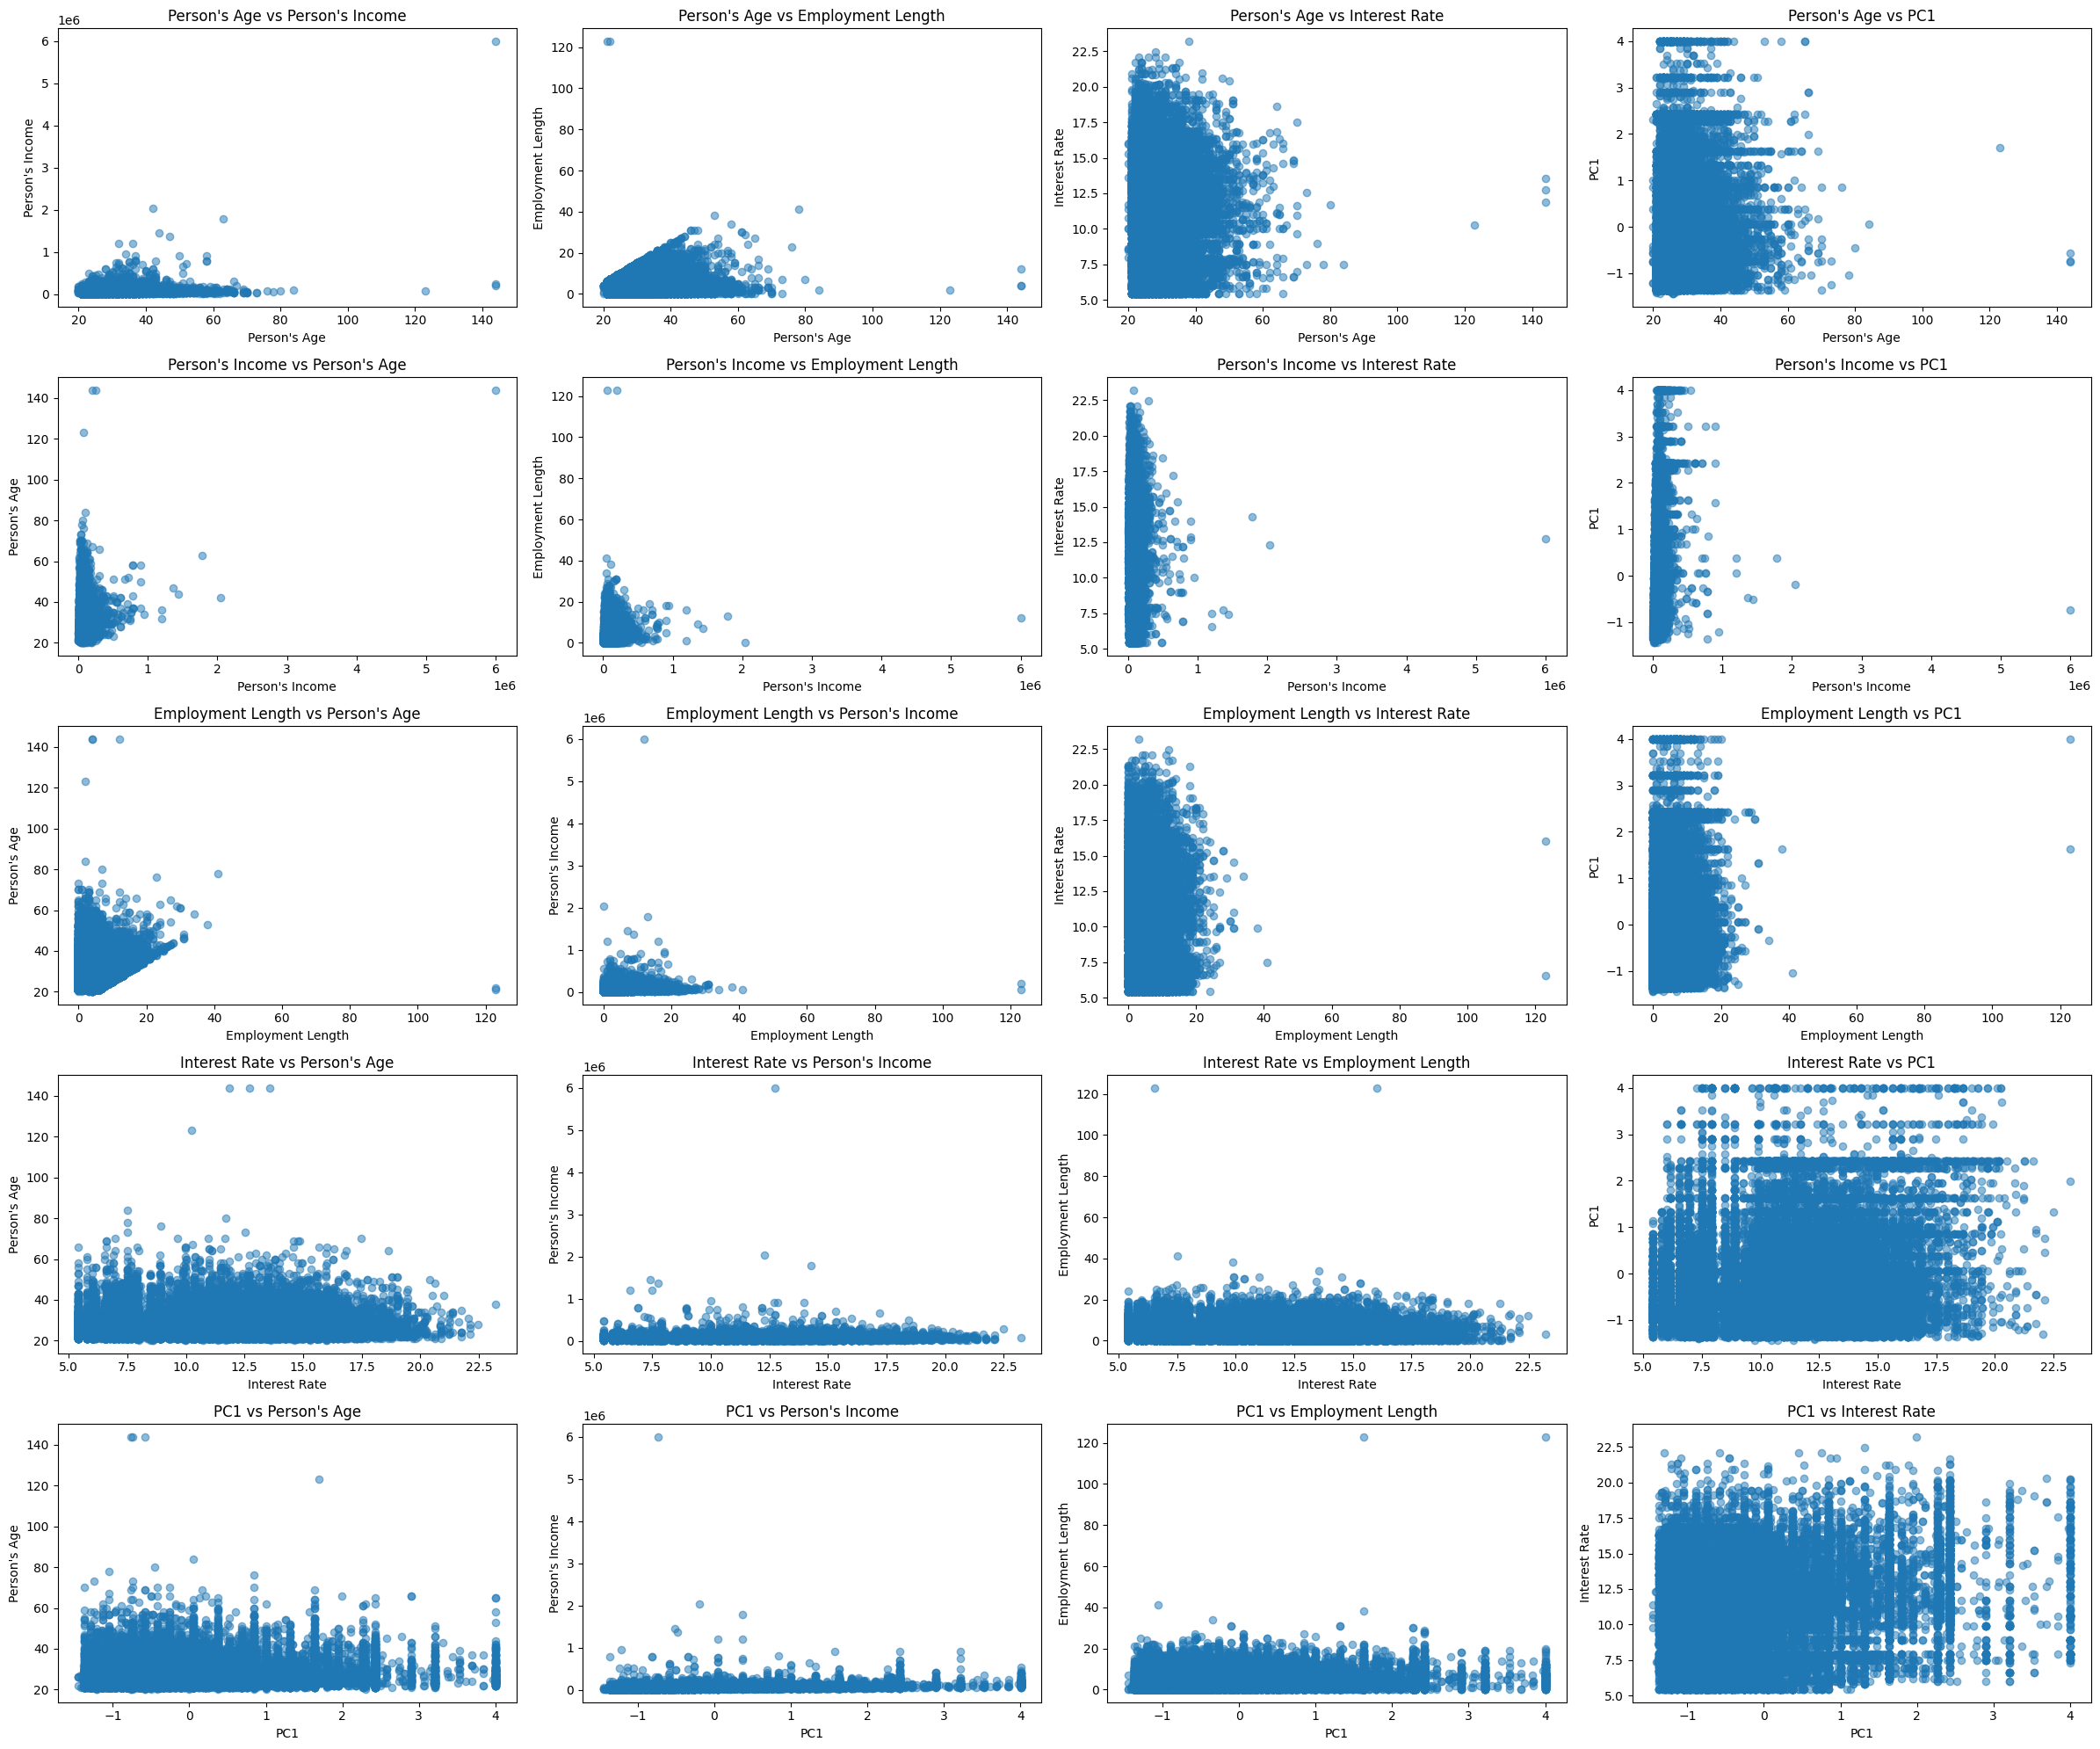

In [21]:
# Getting all the combinations
column_pairs = list(itertools.permutations(num_columns, 2))
n_pairs = len(column_pairs)

# Calculating the grid
n_cols = len(num_columns)-1
n_rows = math.ceil(n_pairs / n_cols)

# Building the plotting grid
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(6*n_cols, 4*n_rows))
axes = axes.flatten()

# Scatterplots
for i, (col1, col2) in enumerate(column_pairs):
    axes[i].scatter(df[col1], df[col2], alpha=0.5)
    axes[i].set_title(f'{col1} vs {col2}')
    axes[i].set_xlabel(col1)
    axes[i].set_ylabel(col2)

# Deleting extended Slots (not needed here)
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

To deal with outliers, we first need to define what we consider an outlier.

A simple approach is to identify them visually (e.g., in a scatterplot or boxplot).

A more advanced approach is to model the data statistically (e.g., assuming a Gaussian distribution), set a threshold, and then remove data points that fall outside this threshold.
This can be done via the Z-Score method. Another common way is to use quantiles and drop all points outside 1.5 times the IQR (interquartile range, based on the 0.25–0.75 quantiles).

Both approaches are valid. However, we want to make sure to retain as much data as possible, so that our model is not prone to errors later on.

We take the approach by doing it feature-wise as we don't have so many features to check.

#### Person's Age

Starting with Person's Age. We can assume there is nobody over 120 years old when taking a loan. 

But what about people around the age of 80 or 70 or even 60?

To make a clean cut, we can take into account our domain knowledge and public health knowledge.

- The global life expectancy is around 76 years in USA.
- The expectancy to have changing income from work is around the age of 67 years in USA where you retire.

Other Factors about the pension cannot be validated as we don't have the data (early pension). Neither can we take the health condition into account as we don't have data from this either. 

Collecting this data and taking them into account would exceed this notebook.
We can also look at our data and calculate the mean time for those people to repay their loan, but for now we can just assume a number suited to our scheme (8 years -> see the credit history data)

So taking this all together we can conclude, that we want to drop all the data with "Person's Age" greater than 59 years.

Let's see how many data points we drop.

In [22]:
print("People over 67 years taking a loan: ", df[df["Person\'s Age"]>=59].shape[0])
print("People under 67 years taking a loan: ", df[df["Person\'s Age"]<59].shape[0])

People over 67 years taking a loan:  76
People under 67 years taking a loan:  28562


We can see it's a lot less than even 1% of our data.

So what about the upper quantile?

In [23]:
Q1 = df["Person's Age"].quantile(0.25)
Q3 = df["Person's Age"].quantile(0.75)
IQR = Q3 - Q1

df_no_outliers = df[
    (df["Person's Age"] >= Q1 - 1.5 * IQR) &
    (df["Person's Age"] <= Q3 + 1.5 * IQR)
]

print("Q1:", Q1)
print("Q3:", Q3)
print("")
print("Original:", df.shape)
print("Without Outliers (IQR):", df_no_outliers.shape)
print("")
print("Outliers:", df.shape[0]-df_no_outliers.shape[0])

Q1: 23.0
Q3: 30.0

Original: (28638, 14)
Without Outliers (IQR): (27340, 14)

Outliers: 1298


In [24]:
df.drop(df[df["Person\'s Age"]>=59].index, inplace=True)
print("People over 67 years taking a loan (updated DataFrame): ", df[df["Person\'s Age"]>=59].shape[0])

People over 67 years taking a loan (updated DataFrame):  0


We can clearly see, we would have dropped way more data with the IQR approach.

#### Person's Income

In the case of person’s income, we cannot make strong assumptions about the data. While it is unlikely that someone earning $6 million per year would take a very small loan, it is still possible. Therefore, we cannot rely on domain knowledge alone to clean the data.

As a result, we use statistical tools for outlier detection, such as the Z-score and the IQR. Since we do not know the true distribution of incomes and they are typically highly skewed, assuming a Gaussian distribution is not reliable. A more robust approach is to use the interquartile range (IQR) to identify and handle potential outliers.

In [25]:
Q1 = df["Person's Income"].quantile(0.25)
Q3 = df["Person's Income"].quantile(0.75)
IQR = Q3 - Q1

df_no_outliers = df[
    (df["Person's Income"] >= Q1 - 1.5 * IQR) &
    (df["Person's Income"] <= Q3 + 1.5 * IQR)
]

print("Q1:", Q1)
print("Q3:", Q3)
print("")
print("Original:", df.shape)
print("Without Outliers (IQR):", df_no_outliers.shape)
print("")
print("Outliers:", df.shape[0]-df_no_outliers.shape[0])
df=df_no_outliers

Q1: 39438.0
Q3: 80000.0

Original: (28562, 14)
Without Outliers (IQR): (27244, 14)

Outliers: 1318


We can check if it's a good assumption by looking up the average earning in the US.
80000$ is the median and mean income in USA, which is not quite what we have here.

In the meaning of our data, we can see that most people taking loans have higher income than the average person in USA.

#### Employment Length

The same reasoning as in Person's Income is applied here too.

In [26]:
Q1 = df["Employment Length"].quantile(0.25)
Q3 = df["Employment Length"].quantile(0.75)
IQR = Q3 - Q1

df_no_outliers = df[
    (df["Employment Length"] >= Q1 - 1.5 * IQR) &
    (df["Employment Length"] <= Q3 + 1.5 * IQR)
]

print("Q1:", Q1)
print("Q3:", Q3)
print("")
print("Original:", df.shape)
print("Without Outliers (IQR):", df_no_outliers.shape)
print("")
print("Outliers:", df.shape[0]-df_no_outliers.shape[0])
df=df_no_outliers

Q1: 2.0
Q3: 7.0

Original: (27244, 14)
Without Outliers (IQR): (26561, 14)

Outliers: 683


#### Interest Rate

The interest rate is in reality a very close to constant variable. This can be observed in our data as well.

After a research we can conclude, that we can't assume there is an interest rate limit that is exceeded here (max of 36%).

So we assume the data is clean in this matter.

#### PC1

This is very interesting to consider. First of all we have to understand what our new PC1 is telling us. 

The first principal component (PC1) captures the largest variation in loan amount and loan percentage of income, while the second component (PC2) captures additional, orthogonal variation. 

Points far from the main cluster in the PC1–PC2 space can be considered outliers, representing unusual combinations of the two features. PCA thus simplifies the data structure and helps identify potential outliers.

We used just the PC1 component so we have to take that into account. We still can proceed with the IQR.


In [27]:
Q1 = df["PC1"].quantile(0.25)
Q3 = df["PC1"].quantile(0.75)
IQR = Q3 - Q1

df_no_outliers = df[
    (df["PC1"] >= Q1 - 1.5 * IQR) &
    (df["PC1"] <= Q3 + 1.5 * IQR)
]

print("Q1:", Q1)
print("Q3:", Q3)
print("")
print("Original:", df.shape)
print("Without Outliers (IQR):", df_no_outliers.shape)
print("")
print("Outliers:", df.shape[0]-df_no_outliers.shape[0])
df=df_no_outliers

Q1: -0.7356725695448006
Q3: 0.3702472402705124

Original: (26561, 14)
Without Outliers (IQR): (25401, 14)

Outliers: 1160


#### Conclusion Numerical Data

We can now visualize the clean data.

NameError: name 'model_names' is not defined

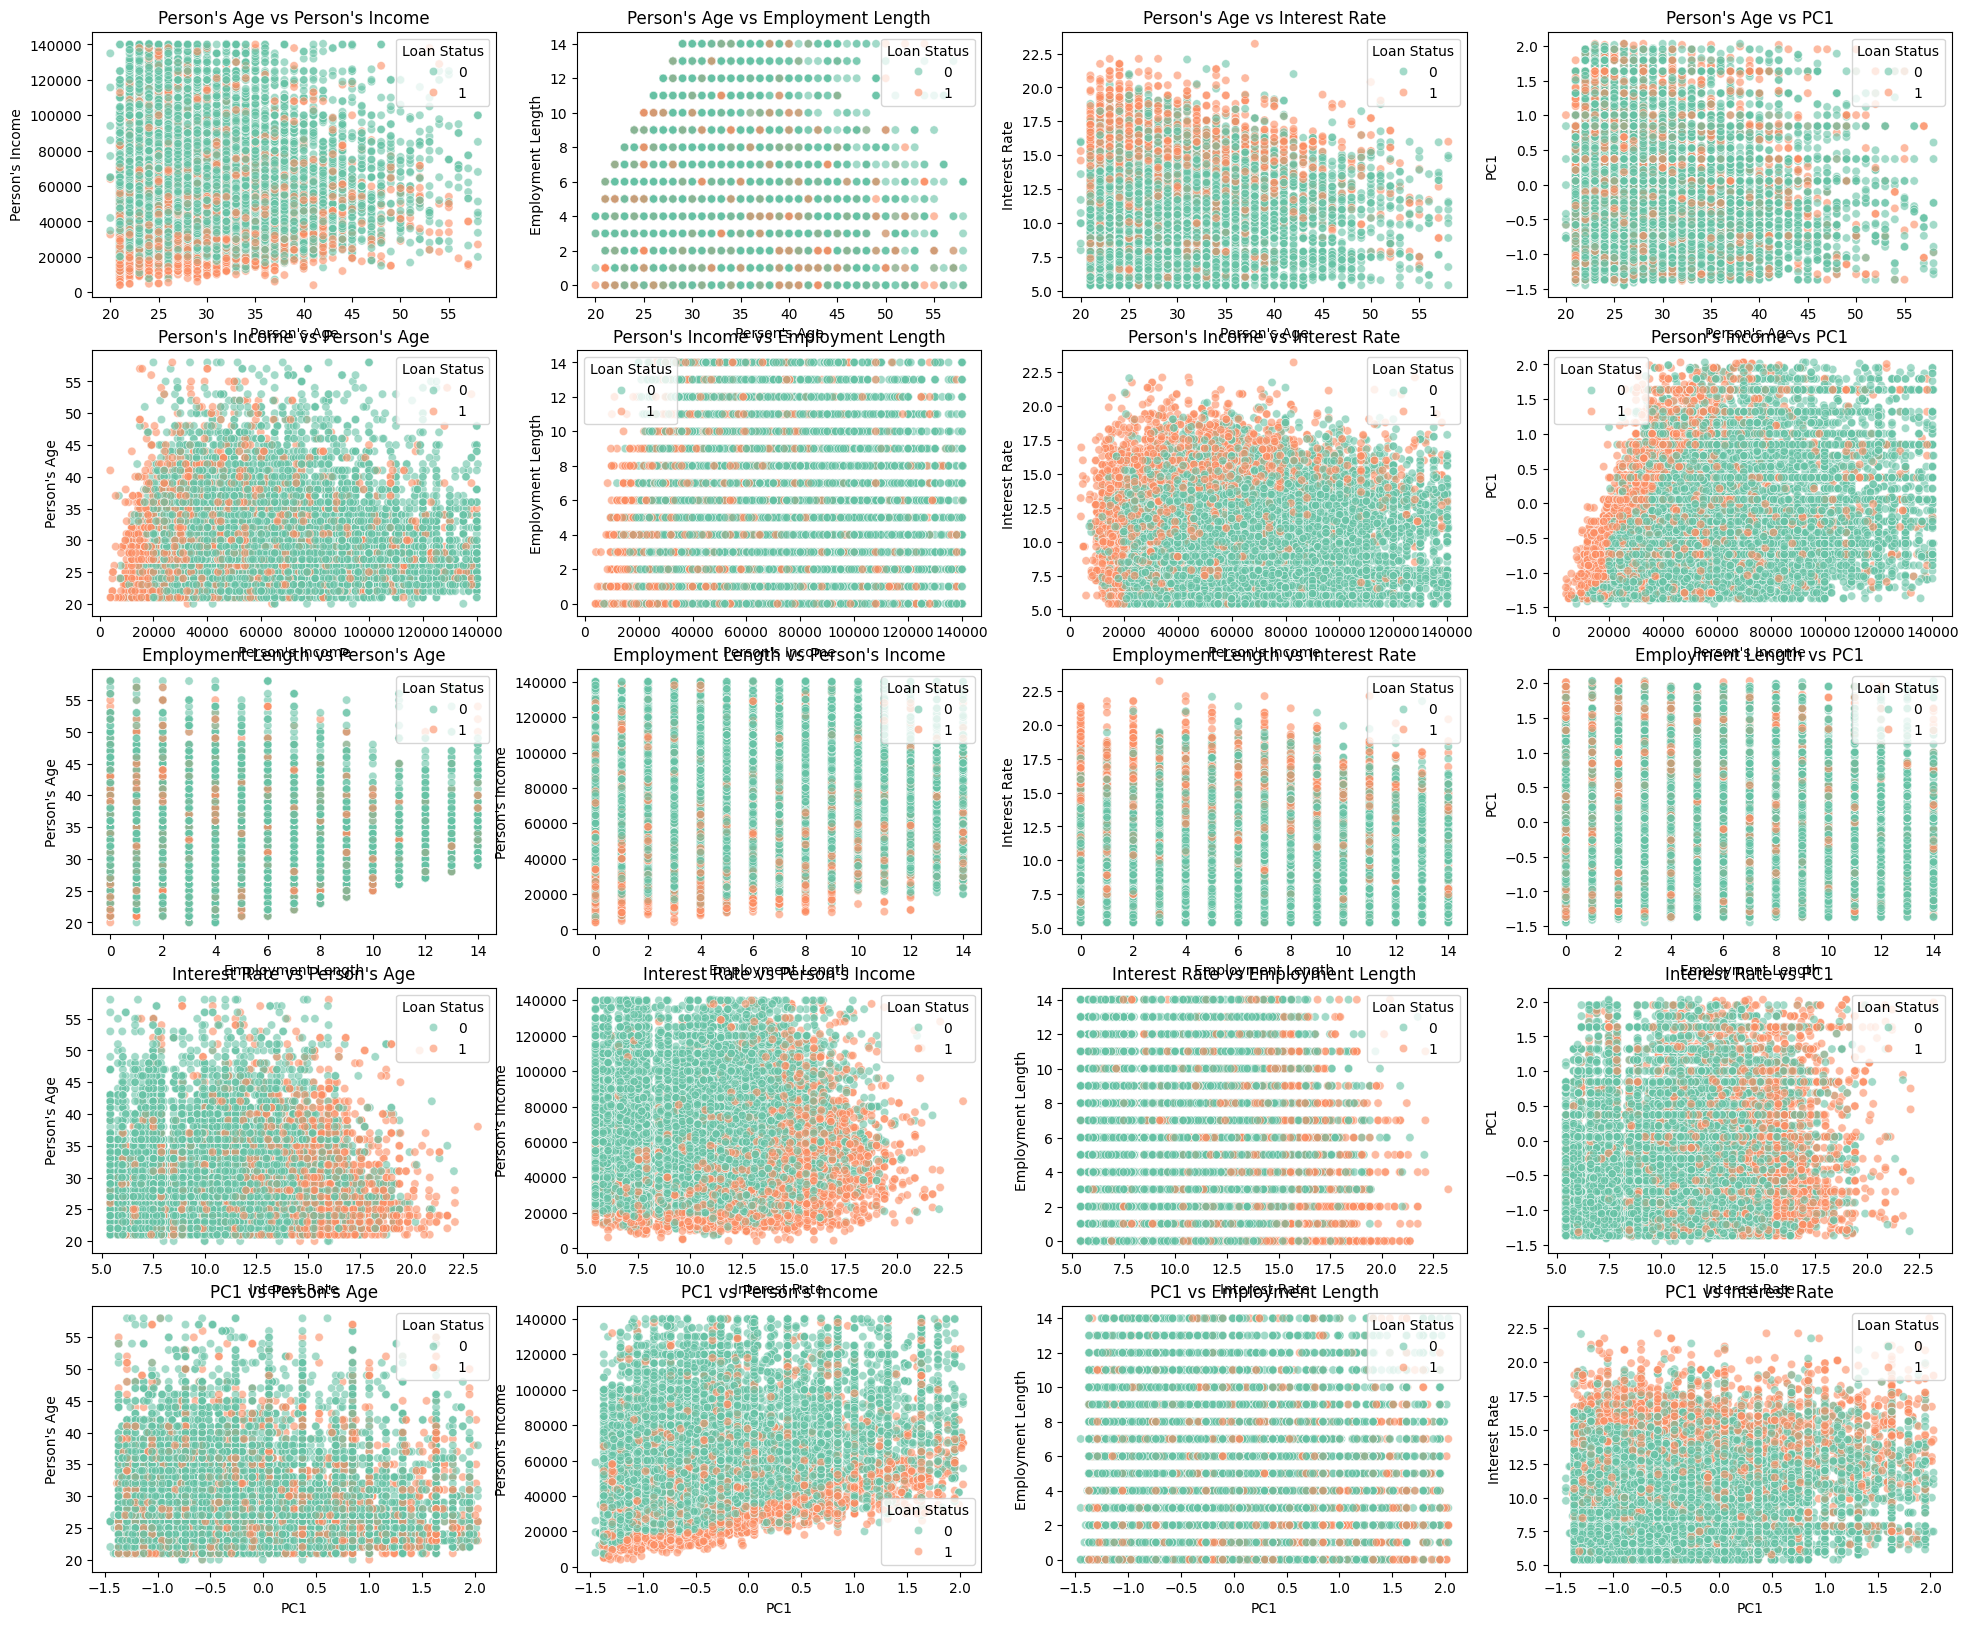

In [28]:
# Get all directed pairs of numerical columns
column_pairs = list(itertools.permutations(num_columns, 2))
n_pairs = len(column_pairs)

# Calculate subplot grid
n_cols = len(num_columns) - 1
n_rows = math.ceil(n_pairs / n_cols)

# Build the plotting grid
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(6*n_cols, 4*n_rows))
axes = axes.flatten()

# Scatterplots with hue
for i, (col1, col2) in enumerate(column_pairs):
    sns.scatterplot(
        data=df,
        x=col1,
        y=col2,
        hue="Loan Status",
        alpha=0.6,
        palette="Set2",
        ax=axes[i]
    )
    axes[i].set_title(f'{col1} vs {col2}')

# Remove unused axes
for j in range(len(model_names), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


We can now continue to scale our data.  
With StandardScaler we assure that our model won't be affected by the magnitude of our data.

### Categorical Data

After going through all the numeric features, we can go on to the categorical features and analyze them.

We start with what we did before and get some descriptive analysis done.

In [ ]:
df_cat=df[cat_columns] #defining a new dataframe with categorical features only
df_cat.info() 

In [ ]:
df_cat.describe()

In [ ]:
distinct_values = df_cat.apply(pd.Series.unique)
print("\nActual distinct values per column:")
distinct_values

In [ ]:
# Calculate subplot grid
n_cols = 2  # Number of columns in the subplot grid
n_rows = math.ceil(len(cat_columns) / n_cols)

# Build the plotting grid
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(7*n_cols, 5*n_rows))
axes = axes.flatten()

# Countplots sorted by value counts
for i, col in enumerate(cat_columns):
    # Get sorted categories by frequency
    order = df[col].value_counts().index
    sns.countplot(data=df, x=col, hue="Loan Status", order=order, palette="Set2", ax=axes[i])
    axes[i].set_title(f"{col} by Loan Status")
    axes[i].tick_params(axis='x', rotation=30)

# Remove unused axes
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

#### Encoding Categorical Variables  

Now that we have a good understanding of the columns, we can encode them using OneHotEncoder.  
We use OneHotEncoder for nearly all our columns (except for Loan Grade) for the following reasons:  
- We have not too many categorical columns
- We don't have a vast variety in our categorical columns
- No order (except for our Loan Grade) 

In [ ]:
# One-hot encode categorical variables, excluding "Loan Grade"
cat_columns_no_grade = [col for col in cat_columns if col != "Loan Grade"]

encoder = OneHotEncoder(drop='first', sparse_output=False)
encoded_cat = encoder.fit_transform(df[cat_columns_no_grade])

# Create DataFrame for encoded features
encoded_cat_df = pd.DataFrame(encoded_cat, columns=encoder.get_feature_names_out(cat_columns_no_grade), index=df.index)

# Concatenate encoded features with numerical features, "Loan Grade", and target
df_encoded = pd.concat([df[num_columns], df[["Loan Grade"]], encoded_cat_df, df['Loan Status']], axis=1)

# Show the first few rows of the encoded DataFrame
df_encoded.head()

In [ ]:
# Ordinal encode "Loan Grade" (A=0, B=1, ..., G=6)
grade_order = ['A', 'B', 'C', 'D', 'E', 'F', 'G']
df['Loan Grade Ordinal'] = df['Loan Grade'].map({grade: idx for idx, grade in enumerate(grade_order)})

# Replace "Loan Grade" in the encoded DataFrame
df_encoded = pd.concat(
    [df[num_columns], df[['Loan Grade Ordinal']], encoded_cat_df, df['Loan Status']],
    axis=1
)

df_encoded.head()

Now that we have changed "Loan Grade" to "Loan Grade Ordinal", we need to update the feature names accordingly. And we should also ensure that the new "Loan Grade Ordinal" feature is included in the list of numerical columns.


In [ ]:
# After creating 'Loan Grade Ordinal'
if "Loan Grade Ordinal" not in num_columns:
    num_columns.append("Loan Grade Ordinal")

## Splitting and scaling data

We split our data into a training set and a test set. The training set is used to train our model, while the test set is used to evaluate its performance.

In [ ]:
# Split features and target
X = df_encoded.drop('Loan Status', axis=1)
y = df_encoded['Loan Status']

# Split into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)

After we split our data into training and test data, we can now scale our numerical features. We do this by using StandardScaler from sklearn.

In [ ]:
# Initialize the scaler
scaler = StandardScaler()

# Fit on training data, transform both train and test
X_train[num_columns] = scaler.fit_transform(X_train[num_columns])
X_test[num_columns] = scaler.transform(X_test[num_columns])

# Check the result
X_train.head()

In [ ]:
print(y_test.value_counts())

print(y_train.value_counts())

## Model Training with Pipelines

We compare four models—Logistic Regression, Random Forest, SVM, and XGBoost—using sklearn.pipeline.Pipeline for clean and modular training.

Steps:

- Model Selection: Covers linear, non-linear, classical, and modern algorithms.

- Pipeline Setup: Each model wrapped in a pipeline; scaling optional.

- Training & Evaluation: Fit on training data, evaluate with confusion matrix and classification report.

- Result Storage: Save models and predictions for further analysis.

We can see that we didn't implement the data scaling in our Pipelines. This is because we already scaled our data before.  
We could add it in the pipeline, but for now it is not necessary, as we only work with one dataset.

The results are stored in a dictionary for easy access.

To be able to see the capabilities of our models, we can take a look at our classification reports.

- accuracy measures how often the classifier is correct.
- Precision measures how many of the predicted positive cases were actually positive (true positives / (true positives + false positives)).
- Recall (also called sensitivity) measures how many of the actual positive cases were correctly identified (true positives / (true positives + false negatives)).
- F1 Score is the harmonic mean of precision and recall, providing a single metric that balances both (2 * (precision * recall) / (precision + recall)). It is useful when you want a balance between precision and recall.

In [ ]:
# Model definitions
models = {
    "Logistic Regression": LogisticRegression(penalty='l2', max_iter=1000, random_state=42, class_weight='balanced'),
    "Random Forest": RandomForestClassifier(n_estimators=1000, max_depth=len(X.columns), class_weight='balanced', random_state=42),
    "SVM": SVC(kernel='rbf', probability=True, class_weight='balanced', random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

results = {}

# Iterate over each model, fit, predict, and print evaluation metrics
for name, model in models.items():
    # Create a pipeline with only the classifier
    pipe = Pipeline([
        ('clf', model)
    ])
    # Fit the model on the training data
    pipe.fit(X_train, y_train)
    # Predict on the test data
    y_pred = pipe.predict(X_test)
    # Print confusion matrix
    print(f"\n{name} Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    # Print classification report (precision, recall, f1-score)
    print(classification_report(y_test, y_pred))
    # Store results for later analysis
    results[name] = {
        "model": pipe,
        "y_pred": y_pred
    }

Let us evaluate the performance of our models.

We will start by visualizing the precision-recall and ROC (Receiver Operating Characteristic) curves to assess how well our models distinguish between classes, especially in predicting the positive class (default).  
These metrics provide a comprehensive view of model performance beyond simple accuracy, highlighting the trade-off between precision and recall as well as the ability to discriminate between classes at various thresholds.

Afterwards, we will examine the confusion matrices to analyze the detailed classification results for each model.

Below, we define a function to plot both the precision-recall and ROC curves for our models.

In [ ]:
def plot_precision_recall_and_roc_curves(classifiers, X_test, y_test, plot_roc=True, thresholds=None):
    """
    Plots precision-recall and optionally ROC curves for a dictionary of classifiers.
    
    Parameters:
        classifiers (dict): Model names as keys and fitted classifiers as values.
        X_test (array-like): Test features.
        y_test (array-like): True labels for test set.
        plot_roc (bool): If True, also plot ROC curves.
        thresholds (list or None): List of thresholds to mark on the curves.
    """

    plt.figure(figsize=(14, 6 if plot_roc else 5))

    # Precision-Recall Curve
    plt.subplot(1, 2 if plot_roc else 1, 1)
    for name, clf in classifiers.items():
        if hasattr(clf, "predict_proba"):
            y_proba = clf.predict_proba(X_test)[:, 1]
        elif hasattr(clf, "decision_function"):
            y_proba = clf.decision_function(X_test)
        else:
            continue

        precision, recall, thresh = precision_recall_curve(y_test, y_proba)
        ap = average_precision_score(y_test, y_proba)
        plt.plot(recall, precision, label=f'{name} (AP={ap:.2f})')

        # Plot threshold markers if provided
        if thresholds is not None:
            for t in thresholds:
                idx = (np.abs(thresh - t)).argmin()
                plt.plot(recall[idx], precision[idx], 'o', label=f'{name} thr={t:.2f}')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.grid(True)

    # ROC Curve
    if plot_roc:
        plt.subplot(1, 2, 2)
        for name, clf in classifiers.items():
            if hasattr(clf, "predict_proba"):
                y_proba = clf.predict_proba(X_test)[:, 1]
            elif hasattr(clf, "decision_function"):
                y_proba = clf.decision_function(X_test)
            else:
                continue

            fpr, tpr, roc_thresh = roc_curve(y_test, y_proba)
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, label=f'{name} (AUC={roc_auc:.2f})')

            # Plot threshold markers if provided
            if thresholds is not None:
                for t in thresholds:
                    idx = (np.abs(roc_thresh - t)).argmin()
                    plt.plot(fpr[idx], tpr[idx], 'o', label=f'{name} thr={t:.2f}')

        plt.plot([0, 1], [0, 1], 'k--', lw=1)
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.show()


In [ ]:
def plot_confusion_matrix(model_name, ax):
    """
    Plots a confusion matrix as a heatmap with counts and percentages for the given model name on the provided Axes.
    Uses global y_test and retrieves y_pred from the results dictionary.
    """
    y_pred = results[model_name]['y_pred']
    cm = confusion_matrix(y_test, y_pred)
    group_names = ["True Neg","False Pos","False Neg","True Pos"]
    group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', 
                xticklabels=['Not Default','Default'], 
                yticklabels=['Not Default','Default'],
                ax=ax)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_title(f'Confusion Matrix: {model_name}')


In [ ]:
fitted_classifiers = {name: res["model"] for name, res in results.items()}
plot_precision_recall_and_roc_curves(fitted_classifiers, X_test, y_test)
plt.show()

- **Precision-Recall Curve**:  
  XGBoost shows the highest average precision, indicating strong performance in identifying true positives, especially in imbalanced datasets. Random Forest and SVM follow closely, while Logistic Regression serves as a baseline.

- **ROC Curve**:  
  XGBoost again leads with the highest AUC, demonstrating excellent class separation. Random Forest and SVM perform well, while Logistic Regression offers reasonable baseline performance.

Overall, XGBoost is the top-performing model across both metrics.

We can now visualize the confusion matrix for each model to see how well they did in detail.

In [ ]:
model_names = list(results.keys())
n_models = len(model_names)
n_rows, n_cols = 2, 2
fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 5 * n_rows))
axes = axes.flatten()

for ax, model_name in zip(axes, model_names):
    plot_confusion_matrix(model_name, ax)

# Hide any unused subplots
for j in range(len(model_names), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


Without any surprise, XGBoost performs best, followed by SVM and Random Forest. Logistic Regression is the weakest model.

This is no surprise as we have a skewed dataset and XGBoost is known to perform well in such scenarios.

## Hyperparameter Tuning with GridSearchCV

Now that we have a good overview of our models, we can try to improve them by tuning their hyperparameters.  
We will use GridSearchCV from sklearn to do this, we focus on the best models we have seen so far (XGBoost, SVM and Random Forest).

We choose a few hyperparameters for each model to tune. The choice of hyperparameters is based on common practices and the specific characteristics of each model. These hyperparameters are known to have a significant impact on model performance, are often tuned in practice and we adjusted them by running and trying it out.

In [ ]:
# Parameter grids for hyperparameter tuning

# Random Forest parameter grid
param_grid_rf = {
    'n_estimators': [100, 200, 400],
    'max_depth': [16, 24, 32, 40],
    'min_samples_split': [2, 5, 10]
}

# SVM parameter grid
param_grid_svm = {
    'C': [1, 10, 100],
    'gamma': ['scale', 1, 100],
    'kernel': ['rbf']
}

# XGBoost parameter grid
param_grid_xgb = {
    'n_estimators': [100, 200, 400],
    'max_depth': [6, 10, 13],
    'learning_rate': [0.1, 0.2, 0.4]
}

In order to deal with the imbalanced dataset, we will use the scale_pos_weight parameter in XGBoost. This parameter helps to balance the positive and negative classes by assigning a higher weight to the minority class (defaults).

Furthermore, we choose f1-score as our scoring metric, as it balances precision and recall, making it the most suitable choice for our use case.

In [ ]:
# Random Forest hyperparameter tuning with GridSearchCV
grid_rf = GridSearchCV(
    RandomForestClassifier(class_weight='balanced'),
    param_grid_rf,
    scoring='f1',
    cv=5,
    n_jobs=-1
)
grid_rf.fit(X_train, y_train)
print("Best Random Forest Parameters:", grid_rf.best_params_)

# SVM hyperparameter tuning with GridSearchCV
grid_svm = GridSearchCV(
    SVC(class_weight='balanced'),
    param_grid_svm,
    scoring='f1',
    cv=5,
    n_jobs=-1
)
grid_svm.fit(X_train, y_train)
print("Best SVM Parameters:", grid_svm.best_params_)

# XGBoost hyperparameter tuning with GridSearchCV
# For the imbalanced dataset, we set scale_pos_weight
ratio = y_train.value_counts()[0] / y_train.value_counts()[1]
grid_xgb = GridSearchCV(
    XGBClassifier(scale_pos_weight=ratio, eval_metric='logloss'),
    param_grid_xgb,
    scoring='f1',
    cv=5,
    n_jobs=-1
)
grid_xgb.fit(X_train, y_train)
print("Best XGBoost Parameters:", grid_xgb.best_params_)

To visualize our results and our improvements, we can plot the precision-recall and ROC curves again to see if we improved our models.
First we visualize the precision-recall and ROC curves again to see our models with the new hyperparameters.  
Then we compare them and finally we see the difference in the classification reports. In the end we can compare the results before and after hyperparameter tuning.

In [ ]:
best_models = {
    "Random Forest (Tuned)": best_rf,
    "SVM (Tuned)": best_svm,
    "XGBoost (Tuned)": best_xgb
}

plot_precision_recall_and_roc_curves(best_models, X_test, y_test)
plt.show()

In [ ]:
# Plot Random Forest (original and tuned)
rf_models = {
    "Random Forest (Original)": fitted_classifiers["Random Forest"],
    "Random Forest (Tuned)": best_rf
}
plot_precision_recall_and_roc_curves(rf_models, X_test, y_test)
plt.show()

# Plot SVM (original and tuned)
svm_models = {
    "SVM (Original)": fitted_classifiers["SVM"],
    "SVM (Tuned)": best_svm
}
plot_precision_recall_and_roc_curves(svm_models, X_test, y_test)
plt.show()

# Plot XGBoost (original and tuned)
xgb_models = {
    "XGBoost (Original)": fitted_classifiers["XGBoost"],
    "XGBoost (Tuned)": best_xgb
}
plot_precision_recall_and_roc_curves(xgb_models, X_test, y_test)
plt.show()


In [ ]:
# --- Classification Reports: Original vs Tuned Models ---

# Random Forest (Original)
print("Random Forest (Original) Classification Report:")
print(classification_report(y_test, results["Random Forest"]['y_pred']))

# Random Forest (Tuned)
print("\nRandom Forest (Tuned) Classification Report:")
y_pred_rf = best_rf.predict(X_test)
print(classification_report(y_test, y_pred_rf))

# SVM (Original)
print("\nSVM (Original) Classification Report:")
print(classification_report(y_test, results["SVM"]['y_pred']))

# SVM (Tuned)
print("\nSVM (Tuned) Classification Report:")
y_pred_svm = best_svm.predict(X_test)
print(classification_report(y_test, y_pred_svm))

# XGBoost (Original)
print("\nXGBoost (Original) Classification Report:")
print(classification_report(y_test, results["XGBoost"]['y_pred']))

# XGBoost (Tuned)
print("\nXGBoost (Tuned) Classification Report:")
y_pred_xgb = best_xgb.predict(X_test)
print(classification_report(y_test, y_pred_xgb))

## Conclusion

In this project, we successfully built a credit risk prediction model using various machine learning algorithms. We explored the dataset in depth, performed extensive feature engineering, and evaluated the model's performance using appropriate metrics. The results indicate that our model can effectively predict credit risk, providing valuable insights for financial institutions.

Throughout the process, we addressed common data challenges such as missing values, outliers, and class imbalance. We applied dimensionality reduction techniques like PCA to improve model performance and reduce multicollinearity. Both categorical and numerical features were carefully preprocessed and encoded to ensure compatibility with different algorithms.

We compared several models, including Logistic Regression, Random Forest, SVM, and XGBoost, and found that XGBoost performed best in terms of precision, recall, and overall predictive power. Hyperparameter tuning further improved the results, demonstrating the importance of model optimization in machine learning workflows.

Overall, this notebook demonstrates a robust end-to-end approach to credit risk prediction, from data cleaning and exploration to model evaluation and interpretation. The developed workflow can serve as a foundation for future enhancements or deployment in real-world financial applications.

Future work could involve incorporating additional data sources, exploring advanced modeling techniques, or implementing the model in a production environment to support decision-making processes in credit risk assessment.